Source: https://www.geeksforgeeks.org/fake-news-detection-using-machine-learning/

In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import pathlib as pl
import os

KeyboardInterrupt: 

In [5]:
df_src = pd.read_csv(pl.Path(os.path.abspath('')).parent.parent.resolve() / "data_files/processed_csv/summarized_corpus_valset2_100k.csv")
df = df_src.copy()


In [ ]:
df = df.drop(["domain", "url", "scraped_at", "title", "authors", "keywords", "tags", "summary"], axis = 1)

In [28]:
df.head()

,id,type,shortened,content_len,mean_word_len,median_word_len,split
0,97157,fake,kouziro launches the frontier nd notebook read...,2218,4.752044,4.0,7
1,79965,fake,the science growing great cannabis legalities ...,2821,5.662562,5.0,7
2,54949,fake,oregon america listen up headline bitcoin bloc...,3956,5.237542,4.0,8
3,66141,fake,memphis police arresting citizens for filming ...,4272,5.213213,4.5,9
4,37165,fake,the real source meltup readers think story fac...,5364,5.298995,5.0,6


In [7]:
df.type.value_counts()

fake        36611
reliable      234
Name: type, dtype: int64

In [8]:
fake = "fake"
real = "reliable"
df = df[(df.type == fake) | (df.type == real)]
df.isnull().sum()

id                 0
type               0
shortened          0
content_len        0
mean_word_len      0
median_word_len    0
split              0
dtype: int64

In [9]:
# Shuffling
df = df.sample(frac=1)
df.reset_index(inplace=True)
df.drop(["index"], axis=1, inplace=True)

<Axes: xlabel='type', ylabel='count'>

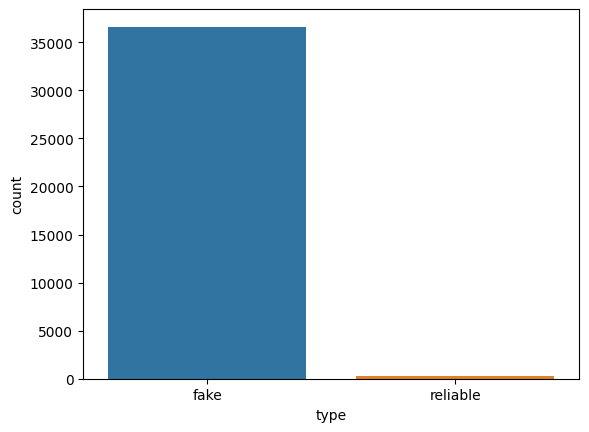

In [10]:
sns.countplot(data=df,
              x='type',
              order=df['type'].value_counts().index)

### Preprocessing and analysis of News column

In [11]:
from tqdm import tqdm
import re
import nltk
nltk.download('punkt')
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem.porter import PorterStemmer
from wordcloud import WordCloud

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\45609\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\45609\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [12]:
def preprocess_text(text_data):
    preprocessed_text = []
      
    for sentence in tqdm(text_data):
        sentence = re.sub(r'[^\w\s]', '', sentence)
        preprocessed_text.append(' '.join(token.lower()
                                  for token in str(sentence).split()
                                  if token not in stopwords.words('english')))
  
    return preprocessed_text

In [14]:
content = "shortened"

preprocessed_review = preprocess_text(df[content].values)
df[content] = preprocessed_review

100%|██████████| 36845/36845 [13:23<00:00, 45.83it/s]


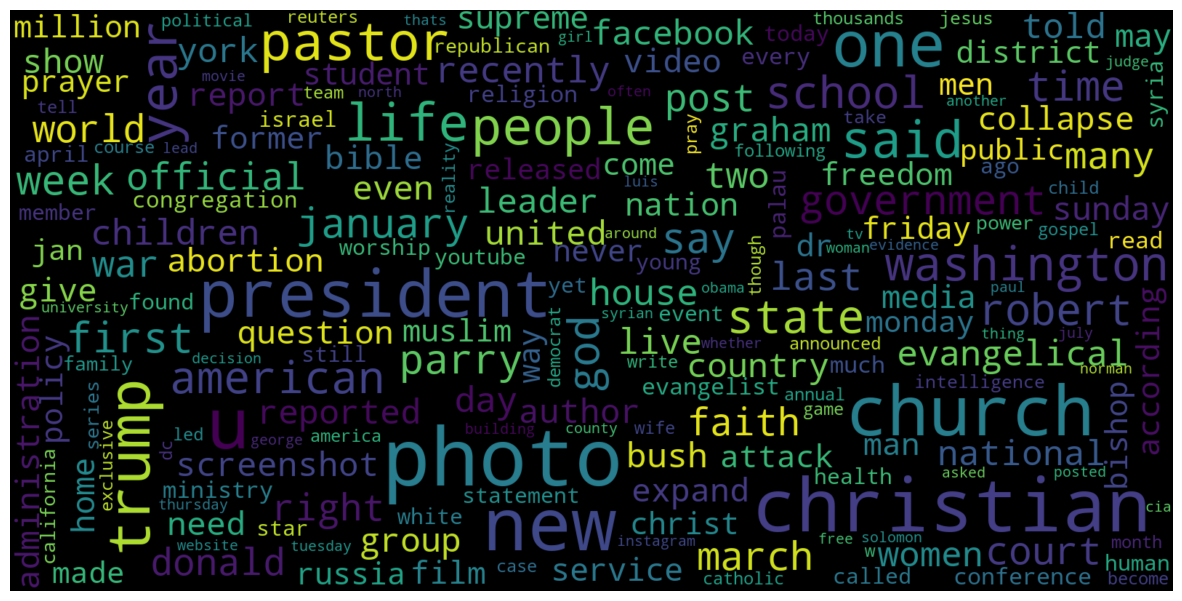

In [15]:
# Real
consolidated = ' '.join(
    word for word in df[content][df['type'] == real].astype(str))
wordCloud = WordCloud(width=1600,
                      height=800,
                      random_state=21,
                      max_font_size=110,
                      collocations=False)
plt.figure(figsize=(15, 10))
plt.imshow(wordCloud.generate(consolidated), interpolation='bilinear')
plt.axis('off')
plt.show()

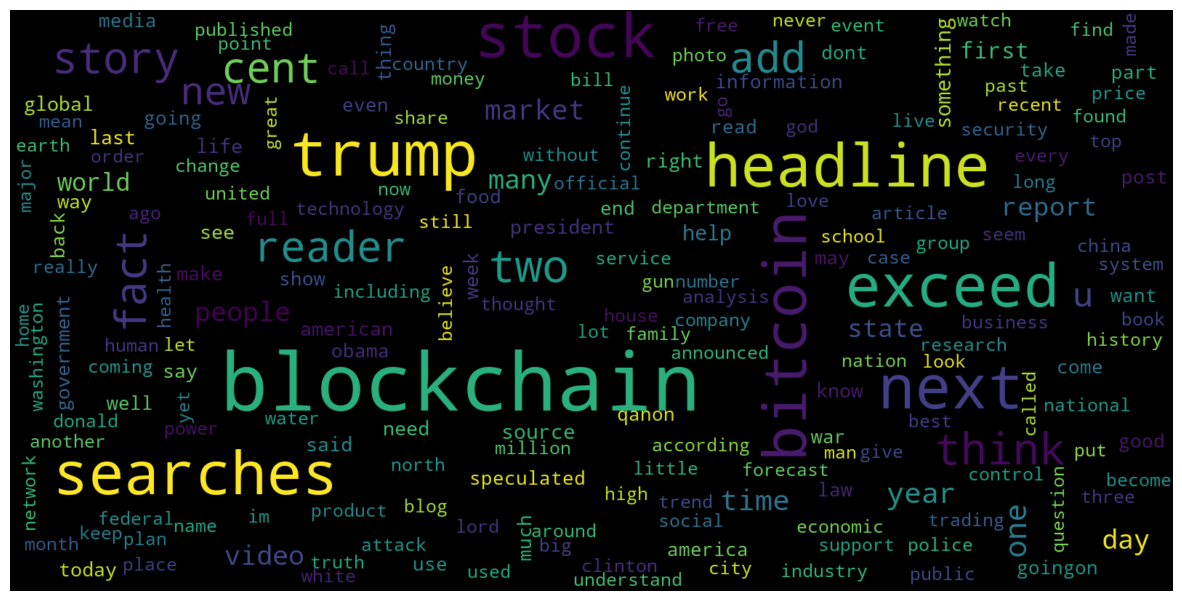

In [18]:
# Fake
consolidated = ' '.join(
    word for word in df[content][df['type'] == fake].astype(str))
wordCloud = WordCloud(width=1600,
                      height=800,
                      random_state=21,
                      max_font_size=110,
                      collocations=False)
plt.figure(figsize=(15, 10))
plt.imshow(wordCloud.generate(consolidated), interpolation='bilinear')
plt.axis('off')
plt.show()

<Axes: title={'center': 'Bar Chart of Top Words Frequency'}, xlabel='Top Words', ylabel='Count'>

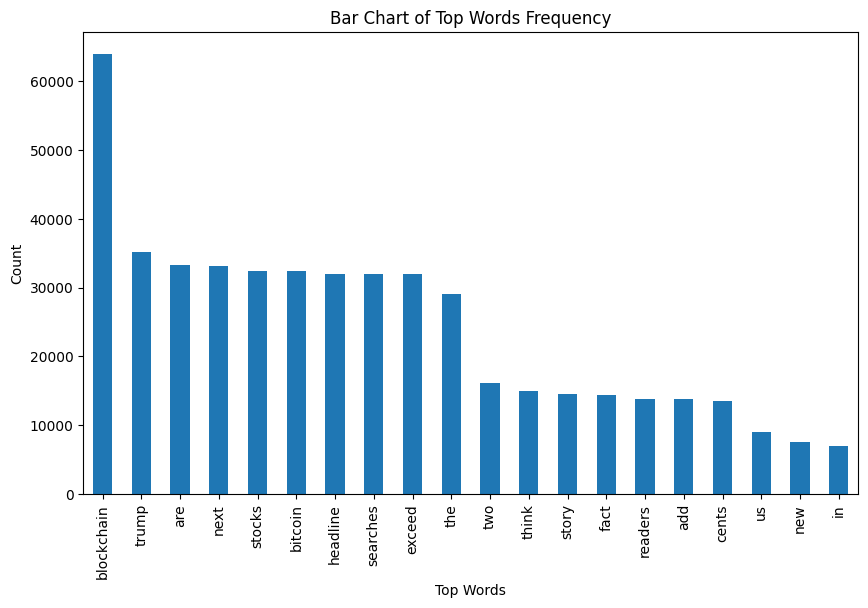

In [20]:
from sklearn.feature_extraction.text import CountVectorizer
  
  
def get_top_n_words(corpus, n=None):
    vec = CountVectorizer().fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0)
    words_freq = [(word, sum_words[0, idx])
                  for word, idx in vec.vocabulary_.items()]
    words_freq = sorted(words_freq, key=lambda x: x[1],
                        reverse=True)
    return words_freq[:n]
  
  
common_words = get_top_n_words(df[content], 20)
df1 = pd.DataFrame(common_words, columns=['Review', 'count'])
  
df1.groupby('Review').sum()['count'].sort_values(ascending=False).plot(
    kind='bar',
    figsize=(10, 6),
    xlabel="Top Words",
    ylabel="Count",
    title="Bar Chart of Top Words Frequency"
)

### Converting text into Vectors
Before converting the data into vectors, split it into train and test.

In [22]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
  
x_train, x_test, y_train, y_test = train_test_split(df[content], 
                                                    df['type'], 
                                                    test_size=0.25)

In [24]:
from sklearn.feature_extraction.text import TfidfVectorizer
  
vectorization = TfidfVectorizer()
x_train = vectorization.fit_transform(x_train)
x_test = vectorization.transform(x_test)

### Model training, Evaluation, and Prediction
Now, the dataset is ready to train the model.

For training we will use Logistic Regression and evaluate the prediction accuracy using accuracy_score.

In [25]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression()
model.fit(x_train, y_train)

# testing the model
print(accuracy_score(y_train, model.predict(x_train)))
print(accuracy_score(y_test, model.predict(x_test)))

0.9933774834437086
0.9944637429439861


Let’s train with Decision Tree Classifier. 

In [26]:
from sklearn.tree import DecisionTreeClassifier

model = DecisionTreeClassifier()
model.fit(x_train, y_train)

# testing the model
print(accuracy_score(y_train, model.predict(x_train)))
print(accuracy_score(y_test, model.predict(x_test)))


1.0
0.9956578376031263


The confusion matrix for Decision Tree Classifier can be implemented with the code below.

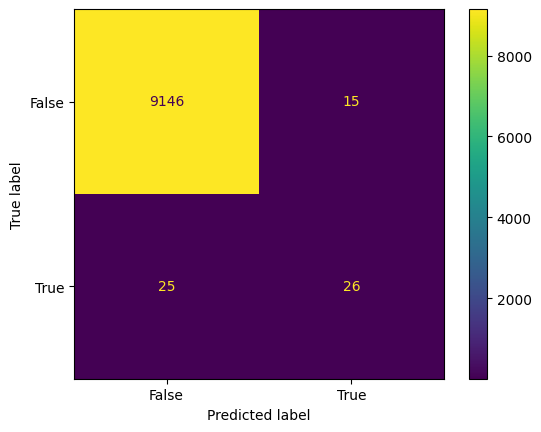

In [27]:
# Confusion matrix of Results from Decision Tree classification
from sklearn import metrics
cm = metrics.confusion_matrix(y_test, model.predict(x_test))
  
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix=cm,
                                            display_labels=[False, True])
  
cm_display.plot()
plt.show()